# Reconocimiento de Comandos de Voz
---
**Configuración General del Entorno de Trabajo**

Esta sección detecta si el notebook está corriendo en un entorno COLAB o en uno LOCAL . Monta la carpeta de Google Drive si corresponde y define constantes para trabajar de forma general con cualquir script. Modificar las definiciones de las carpetas según el entorno y configuración del mismo.

In [192]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:     
    # configuración para notebook en COLAB
    DRIVE_DIR = '/content/drive/MyDrive/' # carpeta G-Drive
    MNT_DRIVE_DIR = '/content/drive/'     # carpeta donde montar G-Drive
    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/Fuentes' 
    DATOS_DIR = DRIVE_DIR + 'Datos/'      # carpeta donde se encuentran los datasets

    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount(MNT_DRIVE_DIR)
else:
    # configuración para notebook con instalación LOCAL
    
    FUENTES_DIR = './RN2022/Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR = 'D:/Internet/G-Drive/Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

---
**Preparación de Dataset**

Para poder trabajar con el dataset se debe:
1. Copiar los archivos Espectros.7z.001, Espectros.7z.002 y Espectros.7z.003 en la carpeta drive de los datos (establecida para este script en DATOS_DIR).
2. Descomprimir con 7zip los archivos

In [193]:
# Los archivos FlowersX16.7z.001 y FlowersX16.7z.002 deben estar en la carpeta
# para descomprimir las imagenes con el compresor 7zip
# !7z x "/content/drive/MyDrive/Datos/Espectros.7z.001" -o"/content/drive/MyDrive/Datos/"


**Preparación de Datos**

In [194]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Flatten,Dropout,Dense, Input, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import skimage.io as io
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob

def import_data(img_list):
    img_data = []
    label_data = []
    
    img_count = len(img_list)
    for i in range(0,img_count):
        img = img_list[i]
        img_read = io.imread(img)

        img_read = img_read/img_read.max() # normaliza pixeles entre 0 y 1
        img_read = img_read.reshape((*img_read.shape,1))

        #img_read = img_read[:,:,0]         # extrae 1er canal porque estan en escala de grises
        #img_read = img_read.flatten()      # redefine como arreglo de 1 dimension
        img_data.append(img_read)          # agrega a lista de imágenes a procesar
        label_data.append(img[img.rindex('_')+1:-4])         # extrae texto de la palabra desde el nombre del archivo
        # muestra progreso en la carga
        if i % 100 == 0:
            print("\rCargando imágenes (%d): %6.2f%%" % (i,100*i/img_count), end="")
    print("\rCargando imágenes (%d): 100.00%%\n" % i)
        
    return np.array(img_data), np.array(label_data)


IMG_ERROR = 'No hay imágenes para cargar. Verificar que la ruta sea correcta y que la carpeta tenga imagenes con la extensión usada'

# %% Carga imágenes de entrenamiento y testeo desde las carpetas

# lista de archivos para entrenamiento

train_img_list = glob.glob(DATOS_DIR + 'Espectros/Train/*.png')
assert len(train_img_list) > 0, IMG_ERROR 

     
# carga las imagenes a partir de los nombres de archivos
xtrain, yraw = import_data(train_img_list)


# %% Establece parámetros de entrenamiento

# tamano de imagen extraido de los datos
IMG_SIZE = (xtrain.shape[1], xtrain.shape[2],1)


# cantidad de pasadas de los datos
EPOCAS = 200
# cantidad de datos a procesar para actualizar pesos
LOTES  = 300

# %% binariza valores del target

# conviertes el id de la clase en "one hot encoding": clase 3 => [0,0,0,1,0,0]
# Binarizador para convertir el nombre de la clase en one hot encoding 
binarizador = preprocessing.LabelBinarizer()
ytrain= binarizador.fit_transform(yraw)

# cantidad de clases
# N_CLASSES = len(np.unique(yraw))
CLASES  = binarizador.classes_

# %% Separa los datos y clase en grupo de entrenamiento y validacion
x_train, x_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size = 0.10, shuffle=True)

Cargando imágenes (10281): 100.00%



**Contrucción del Modelo**

In [195]:
def build_model(img_size, classes):
    ACTIVATION = 'LeakyReLU'
    model = Sequential()
 
    model.add(InputLayer(input_shape=img_size))

    # CONV => RELU => BN => POOL
    model.add(Conv2D(16, (3, 3), strides=(1,1), padding="same", activation=ACTIVATION))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), strides=(1,1), padding="same", activation=ACTIVATION))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), strides=(1,1), padding="same", activation=ACTIVATION))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding="same", activation=ACTIVATION))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding="same", activation=ACTIVATION))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

        
    model.add(Flatten())
    
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation='softmax'))

    return model    

# obtiene la arquitectura para el modelo y lo compila
model = build_model(IMG_SIZE, len(CLASES))
model.summary()
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])



Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_154 (Conv2D)          (None, 64, 65, 16)        160       
_________________________________________________________________
max_pooling2d_154 (MaxPoolin (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_154 (Bat (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_155 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_155 (Bat (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 16, 16, 32)      

**Entrenamiento de Modelo**

In [196]:
# %% Entrena el modelo

es = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True) 

# entrena el modelo y guarda la historira del progreso    
H=model.fit(x = x_train, y = y_train, batch_size = LOTES, epochs = EPOCAS, 
          validation_data = (x_val, y_val), callbacks=[es])


Epoch 1/200
31/31 [==============================] - 6s 128ms/step - loss: 1.8498 - accuracy: 0.4386 - val_loss: 2.6867 - val_accuracy: 0.0739
Epoch 2/200
31/31 [==============================] - 3s 110ms/step - loss: 1.0473 - accuracy: 0.7304 - val_loss: 2.7234 - val_accuracy: 0.0739
Epoch 3/200
31/31 [==============================] - 3s 113ms/step - loss: 0.7871 - accuracy: 0.8021 - val_loss: 2.8708 - val_accuracy: 0.1098
Epoch 4/200
31/31 [==============================] - 4s 113ms/step - loss: 0.6380 - accuracy: 0.8396 - val_loss: 2.8695 - val_accuracy: 0.1467
Epoch 5/200
31/31 [==============================] - 3s 112ms/step - loss: 0.5309 - accuracy: 0.8680 - val_loss: 2.8888 - val_accuracy: 0.1302
Epoch 6/200
31/31 [==============================] - 3s 113ms/step - loss: 0.4464 - accuracy: 0.8917 - val_loss: 3.0724 - val_accuracy: 0.1778
Epoch 7/200
31/31 [==============================] - 3s 113ms/step - loss: 0.3740 - accuracy: 0.9126 - val_loss: 2.9492 - val_accuracy: 0.0914


Porcentaje de acierto del modelo con datos de entrenamiento...:  99.99%
Porcentaje de acierto del modelo con datos de validación......:  95.04%


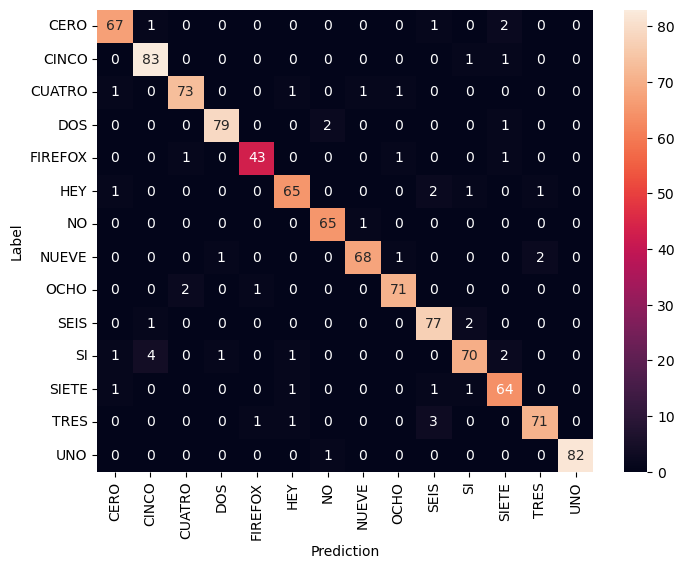

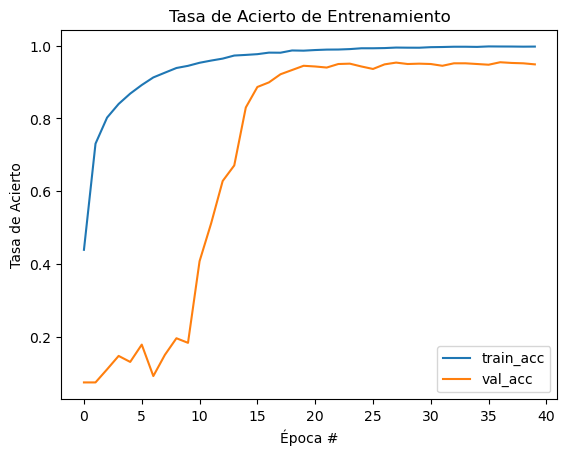

Cargando imágenes (6348): 100.00%

Porcentaje de acierto del modelo con datos de testeo..........:  78.55%


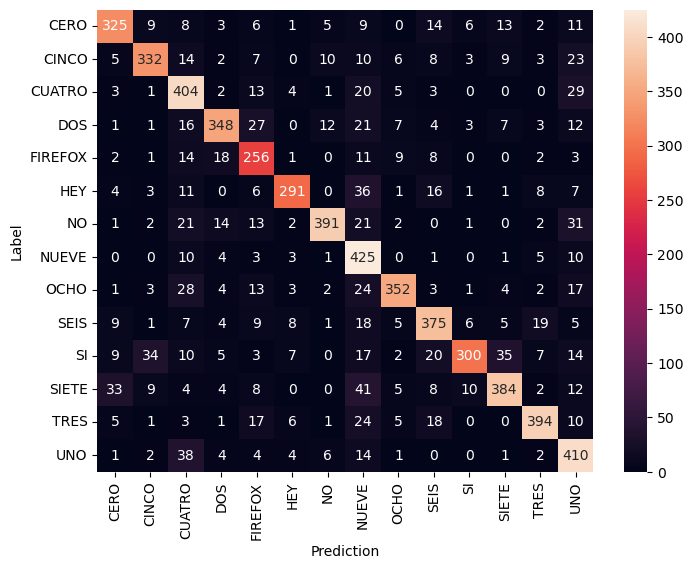

In [197]:
# %% Evalua e informa resultado de entrenamiento, validación y testeo
# evalua el modelo con los datos de entreanmiento
pred = model.evaluate(x_train, y_train, verbose=0)
tasa_ent = pred[1]*100
print("\nPorcentaje de acierto del modelo con datos de entrenamiento...: %6.2f%%" % tasa_ent)

# evalua el modelo con los datos de validacion
y_pred = model.predict(x_val)
y_pred_tx = binarizador.inverse_transform(y_pred)
y_val_tx = binarizador.inverse_transform(y_val)
tasa_val = 100*np.sum(y_pred_tx==y_val_tx)/len(y_val)

print("Porcentaje de acierto del modelo con datos de validación......: %6.2f%%" % tasa_val)

confusion_mtx = confusion_matrix(y_val_tx, y_pred_tx)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=CLASES,
            yticklabels=CLASES,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')



# plot the training loss and accuracy
plt.figure()
#plt.plot(N, H.history["loss"], label="train_loss")
#plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Tasa de Acierto de Entrenamiento")
plt.xlabel("Época #")
plt.ylabel("Tasa de Acierto")
plt.legend(loc="lower right")

plt.show()

y_val#%% Verificación con datos de testeo
img_list = glob.glob(DATOS_DIR + 'Espectros/Test/*.png')
assert len(img_list) > 0, IMG_ERROR 

     
# carga las imagenes a partir de los nombres de archivos
x_test, yraw = import_data(img_list)
#y_test = binarizador.transform(yraw)
y_test_tx = yraw

# evalua el modelo con los datos de validacion
y_pred = model.predict(x_test)
y_pred_tx = binarizador.inverse_transform(y_pred)

tasa_test = 100*np.sum(y_pred_tx==y_test_tx)/len(y_test_tx)

print("Porcentaje de acierto del modelo con datos de testeo..........: %6.2f%%" % tasa_test)

confusion_mtx = confusion_matrix(y_test_tx, y_pred_tx)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=CLASES,
            yticklabels=CLASES,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label');
